In [ ]:
# Libraries
import numpy as np
import pandas as pd
import requests
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.colors as mcolors

In [ ]:
# Function to fetch multiple indicators from World Bank API
def fetch_world_bank_data(indicators, countries, start_year, end_year):
    records = []
    for indicator in indicators:
        url = (
               f"http://api.worldbank.org/v2/country/{';'.join(countries)}"
               f"/indicator/{indicator}?date={start_year}:{end_year}&format=json&per_page=1000"
              )
        response = requests.get(url)
        data = response.json()
        if response.status_code != 200 or not data or 'message' in data[0]:
            raise ValueError(f"Error fetching data for {indicator} from World Bank API")

        for entry in data[1]:
            if entry['value'] is not None:
                records.append([entry['country']['id'], entry['date'], indicator, entry['value']])

    df = pd.DataFrame(records, columns = ['Country', 'Year', 'Indicator', 'Value'])
    return df.pivot_table(index = ['Country', 'Year'], columns = 'Indicator', values = 'Value').reset_index()

countries = [
             "USA", "CAN", "GBR", "DEU", "FRA",
             "JPN", "CHN", "IND", "BRA", "SGP",
             "AUS", "ITA", "KOR", "ESP", "MEX",
             "SAU", "ZAF", "IDN", "TUR", "NLD",
             "CHE", "NOR", "SWE", "POL", "EGY"
             ]

indicators = [
              "NY.GDP.MKTP.CD",  # GDP (current US$)
              "FP.CPI.TOTL",  # Inflation, consumer prices (annual %)
              "NE.EXP.GNFS.ZS",  # Exports of goods and services (% of GDP)
              "NE.IMP.GNFS.ZS",  # Imports of goods and services (% of GDP)
              "SP.POP.TOTL",  # Total population
              "EG.USE.PCAP.KG.OE",  # Energy use (kg of oil equivalent per capita)
              "SP.URB.TOTL.IN.ZS",  # Urban population (% of total)
              "AG.LND.TOTL.K2",  # Arable land (hectares)
              "NE.GDI.TOTL.ZS"  # Gross domestic investment (% of GDP)
             ]

start_year, end_year = 1975, 2010

df = fetch_world_bank_data(indicators, countries, start_year, end_year)

country_dfs = {}

# Filling null values (not a lot of them)
for country in df['Country'].unique():

    country_df = df[df['Country'] == country].copy()

    country_df.loc[:, country_df.columns[3:]] = country_df.loc[:, country_df.columns[3:]]. \
                                                apply(lambda col: col.fillna(col.mean()), axis = 0)

    country_dfs[f'{country}'] = country_df

df = pd.concat(country_dfs.values(), ignore_index = True)
df.columns.name = ''

# Target and features
target = 'NY.GDP.MKTP.CD'
features = [col for col in df.columns if col not in ['Country', 'Year', target]]

# Standardizing features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df[features])

# Applying PCA (set n_components to the number of features, which is the max number of principal components)
pca = PCA(n_components = len(features))
principal_components = pca.fit_transform(X_scaled)

# Creating the DataFrame with principal components
principal_df = pd.DataFrame(principal_components, columns = [f'PC{i+1}' for i in range(len(features))])
final_df = pd.concat([df[['Country', 'Year', target]], principal_df], axis = 1)

# Explained variance
explained_variance = pca.explained_variance_ratio_

# Adding a 0 at the beginning of the cumulative sum
cumulative_variance = np.insert(np.cumsum(explained_variance), 0, 0)

# Printing variance explained by the first few components
print(f"Variance explained by first component: {explained_variance[0] * 100:.2f} %")
print(f"Variance explained by first two components: {explained_variance[:2].sum() * 100:.2f} %")
print(f"Variance explained by first three components: {explained_variance[:3].sum() * 100:.2f} %")

Variance explained by first component: 37.56 %
Variance explained by first two components: 60.02 %
Variance explained by first three components: 78.33 %


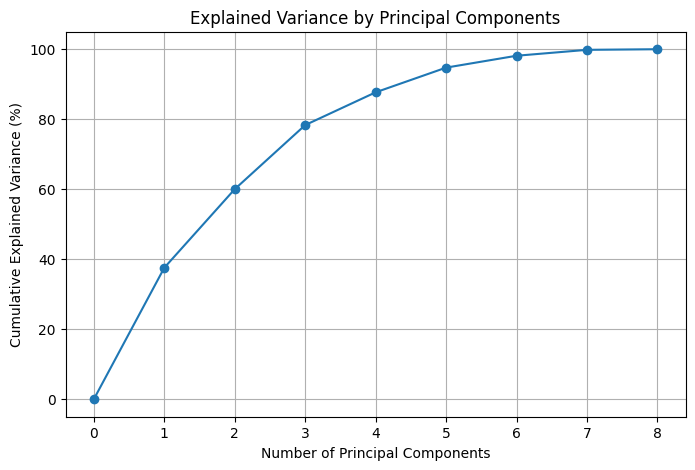

In [ ]:
# Plot variance explained
plt.figure(figsize = (8, 5))
plt.plot(cumulative_variance * 100, marker = 'o')
plt.xlabel("Number of Principal Components")
plt.ylabel("Cumulative Explained Variance (%)")
plt.title("Explained Variance by Principal Components")
plt.xticks(np.arange(0, len(features) + 1))
plt.grid()
plt.show()

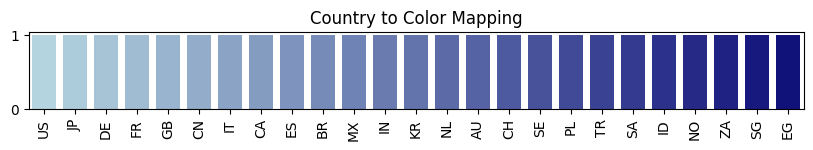

In [ ]:
# Color formatting
avg_gdp_growth = final_df.groupby('Country')['NY.GDP.MKTP.CD'].mean().sort_values(ascending = False)

# Sort the countries by GDP growth in descending order
sorted_countries = avg_gdp_growth.index

# Create a color palette where darker colors represent higher GDP growth
colors = [(0, "lightblue"), (1, "darkblue")]
cmap = mcolors.LinearSegmentedColormap.from_list("blue_gradient", colors, N = len(sorted_countries))

# Generate color values for each country
country_palette = [cmap(i / (len(sorted_countries) - 1)) for i in range(len(sorted_countries))]

# Map countries to colors
country_color_map = {country: color for country, color in zip(sorted_countries, country_palette)}

plt.figure(figsize = (10, 1))
sns.barplot(x = list(country_color_map.keys()), y = [1] * len(country_color_map),
            palette = country_color_map, hue = list(country_color_map.keys()), legend = False)

plt.xticks(rotation = 90)
plt.title("Country to Color Mapping")
plt.show()

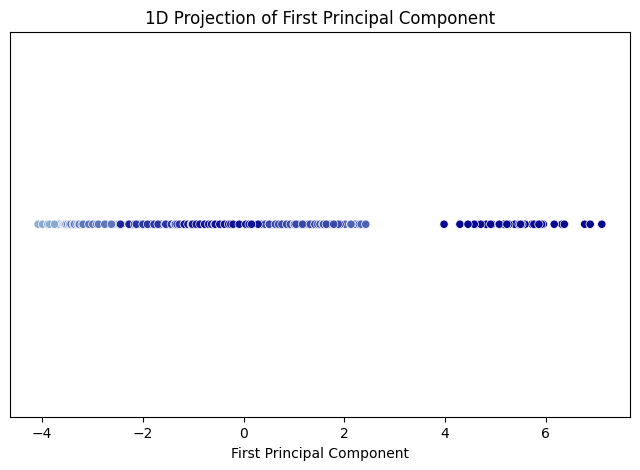

In [ ]:
# 1D plot
plt.figure(figsize = (8, 5))
sns.scatterplot(x = final_df['PC1'], y = np.zeros_like(final_df['PC1']),
                palette = country_color_map, hue = final_df['Country'], legend = None)
plt.xlabel("First Principal Component")
plt.title("1D Projection of First Principal Component")
plt.yticks([])
plt.show()

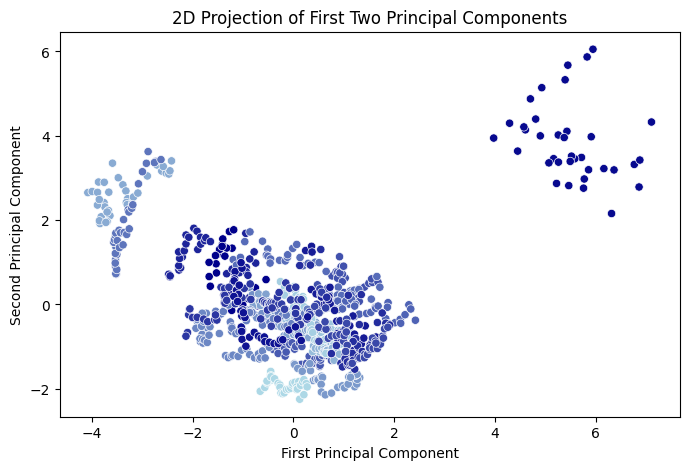

In [ ]:
# 2D plot
plt.figure(figsize = (8, 5))
sns.scatterplot(x = final_df['PC1'], y = final_df['PC2'],
                palette = country_color_map, hue = final_df['Country'], legend = None)
plt.xlabel("First Principal Component")
plt.ylabel("Second Principal Component")
plt.title("2D Projection of First Two Principal Components")
plt.show()

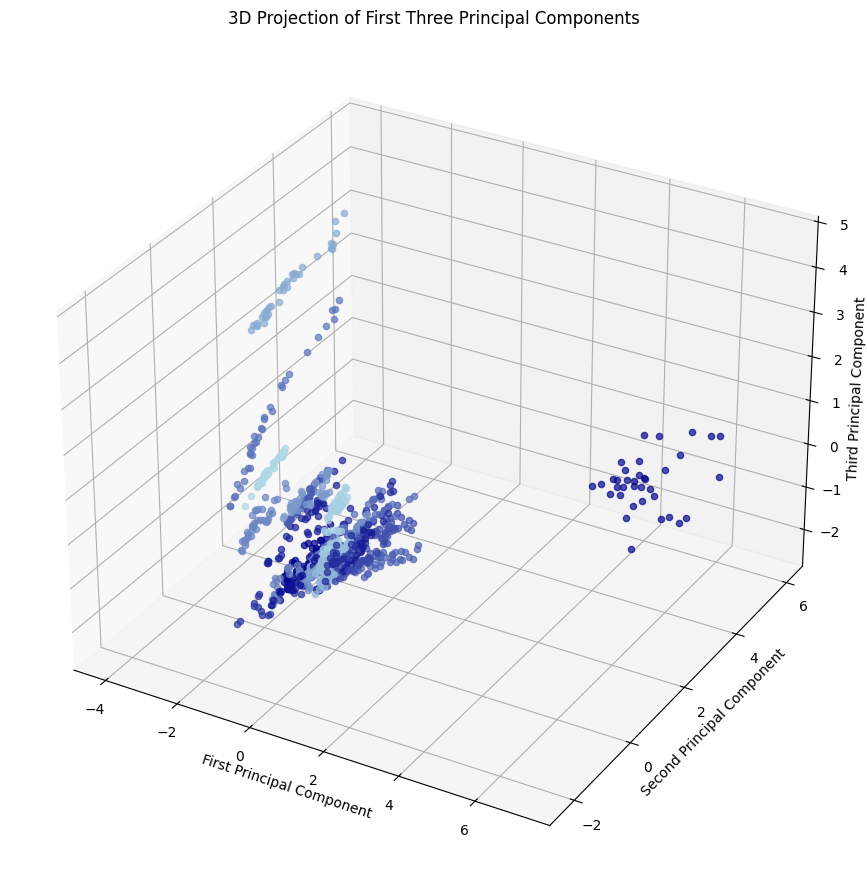

In [ ]:
# 3D plot
fig = plt.figure(figsize = (12, 11))
ax = fig.add_subplot(111, projection = '3d')

# Map each point to its corresponding color
for i, country in enumerate(final_df['Country']):
    ax.scatter(final_df['PC1'][i], final_df['PC2'][i], final_df['PC3'][i],
               color = country_color_map[country], alpha = 0.7)

ax.set_xlabel("First Principal Component", labelpad = 0)
ax.set_ylabel("Second Principal Component", labelpad = 0)
ax.set_zlabel("Third Principal Component", labelpad = 0)
ax.set_title("3D Projection of First Three Principal Components")
plt.show()

Broadly speaking, the behavior of the different countries is similar across the 3 graphs plotted. In particular, Singapore is an outlier across these plots successively. Aside from that, there isn't a lot of regularity which allows us to seperate countries (for example, there doesn't seem to be a large difference between developed and developing countries as such).